<a href="https://colab.research.google.com/github/filipemtz/neuralnets/blob/main/cnn_kaggle_brain_hemorrhage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [39]:
!pip install -q kaggle

In [40]:
from google.colab import files
_ = files.upload()

Saving kaggle.json to kaggle (2).json


In [41]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets list

mkdir: cannot create directory ‘/root/.kaggle’: File exists
ref                                                         title                                              size  lastUpdated          downloadCount  
----------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  
gpreda/reddit-vaccine-myths                                 Reddit Vaccine Myths                              237KB  2021-11-02 21:56:08          15104  
crowww/a-large-scale-fish-dataset                           A Large Scale Fish Dataset                          3GB  2021-04-28 17:03:01           9171  
imsparsh/musicnet-dataset                                   MusicNet Dataset                                   22GB  2021-02-18 14:12:19           4079  
dhruvildave/wikibooks-dataset                               Wikibooks Dataset                                   2GB  2021-10-22 10:48:21           3376  
promptcloud/care

In [42]:
!kaggle datasets download -d vbookshelf/computed-tomography-ct-images

computed-tomography-ct-images.zip: Skipping, found more recently modified local copy (use --force to force download)


In [43]:
!unzip computed-tomography-ct-images.zip -d computed-tomography-ct-images

A saída de streaming foi truncada nas últimas 5000 linhas.
  inflating: computed-tomography-ct-images/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0/Patients_CT/053/brain/10.jpg  
  inflating: computed-tomography-ct-images/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0/Patients_CT/053/brain/11.jpg  
  inflating: computed-tomography-ct-images/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0/Patients_CT/053/brain/12.jpg  
  inflating: computed-tomography-ct-images/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0/Patients_CT/053/brain/13.jpg  
  inflating: computed-tomography-ct-images/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0/Patients_CT/053/brain/14.jpg  
  inflating: computed-tomography-ct-images/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0/

In [44]:
import os
from sklearn.model_selection import train_test_split

DATA_PATH = "computed-tomography-ct-images/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0/"

patients = [int(d) for d in os.listdir(f"{DATA_PATH}/Patients_CT/")]
train_patients, test_patients = train_test_split(patients)

print(f"num train patients: {len(train_patients)} num test patients: {len(test_patients)}")


num train patients: 61 num test patients: 21


In [45]:
import pandas as pd 

diagnostics = pd.read_csv(f"{DATA_PATH}/hemorrhage_diagnosis.csv")
diagnostics.head()

PatientNumber  SliceNumber  ...  No_Hemorrhage  Fracture_Yes_No
0             49            1  ...              1                0
1             49            2  ...              1                0
2             49            3  ...              1                0
3             49            4  ...              1                0
4             49            5  ...              1                0

[5 rows x 9 columns]

In [46]:
diagnostics[diagnostics['PatientNumber'] == 74]

PatientNumber  SliceNumber  ...  No_Hemorrhage  Fracture_Yes_No
761             74            1  ...              1                0
762             74            2  ...              1                0
763             74            3  ...              1                0
764             74            4  ...              1                0
765             74            5  ...              1                0
766             74            6  ...              1                0
767             74            7  ...              1                0
768             74            8  ...              1                0
769             74            9  ...              1                0
770             74           10  ...              1                0
771             74           11  ...              1                0
772             74           12  ...              0                0
773             74           13  ...              0                0
774             74           14  ...              0                0
775             74           15  ...              0                0
776             74           16  ...              0                0
777             74           17  ...              1                0
778             74           18  ...              0                1
779             74           19  ...              0                1
780             74           20  ...              0                1
781             74           21  ...              0                1
782             74           22  ...              0                1
783             74           23  ...              0                1
784             74           24  ...              0                1
785             74           25  ...              0                0
786             74           26  ...              1                0
787             74           27  ...              1                0
788             74           28  ...              1                0
789             74           29  ...              1                0
790             74           30  ...              1                0
791             74           31  ...              1                0
792             74           32  ...              1                0
793             74           33  ...              1                0

[33 rows x 9 columns]

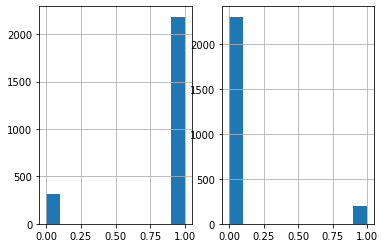

In [47]:
import matplotlib.pyplot as plt

plt.subplot(1, 2, 1)
diagnostics['No_Hemorrhage'].hist()
plt.subplot(1, 2, 2)
diagnostics['Fracture_Yes_No'].hist()



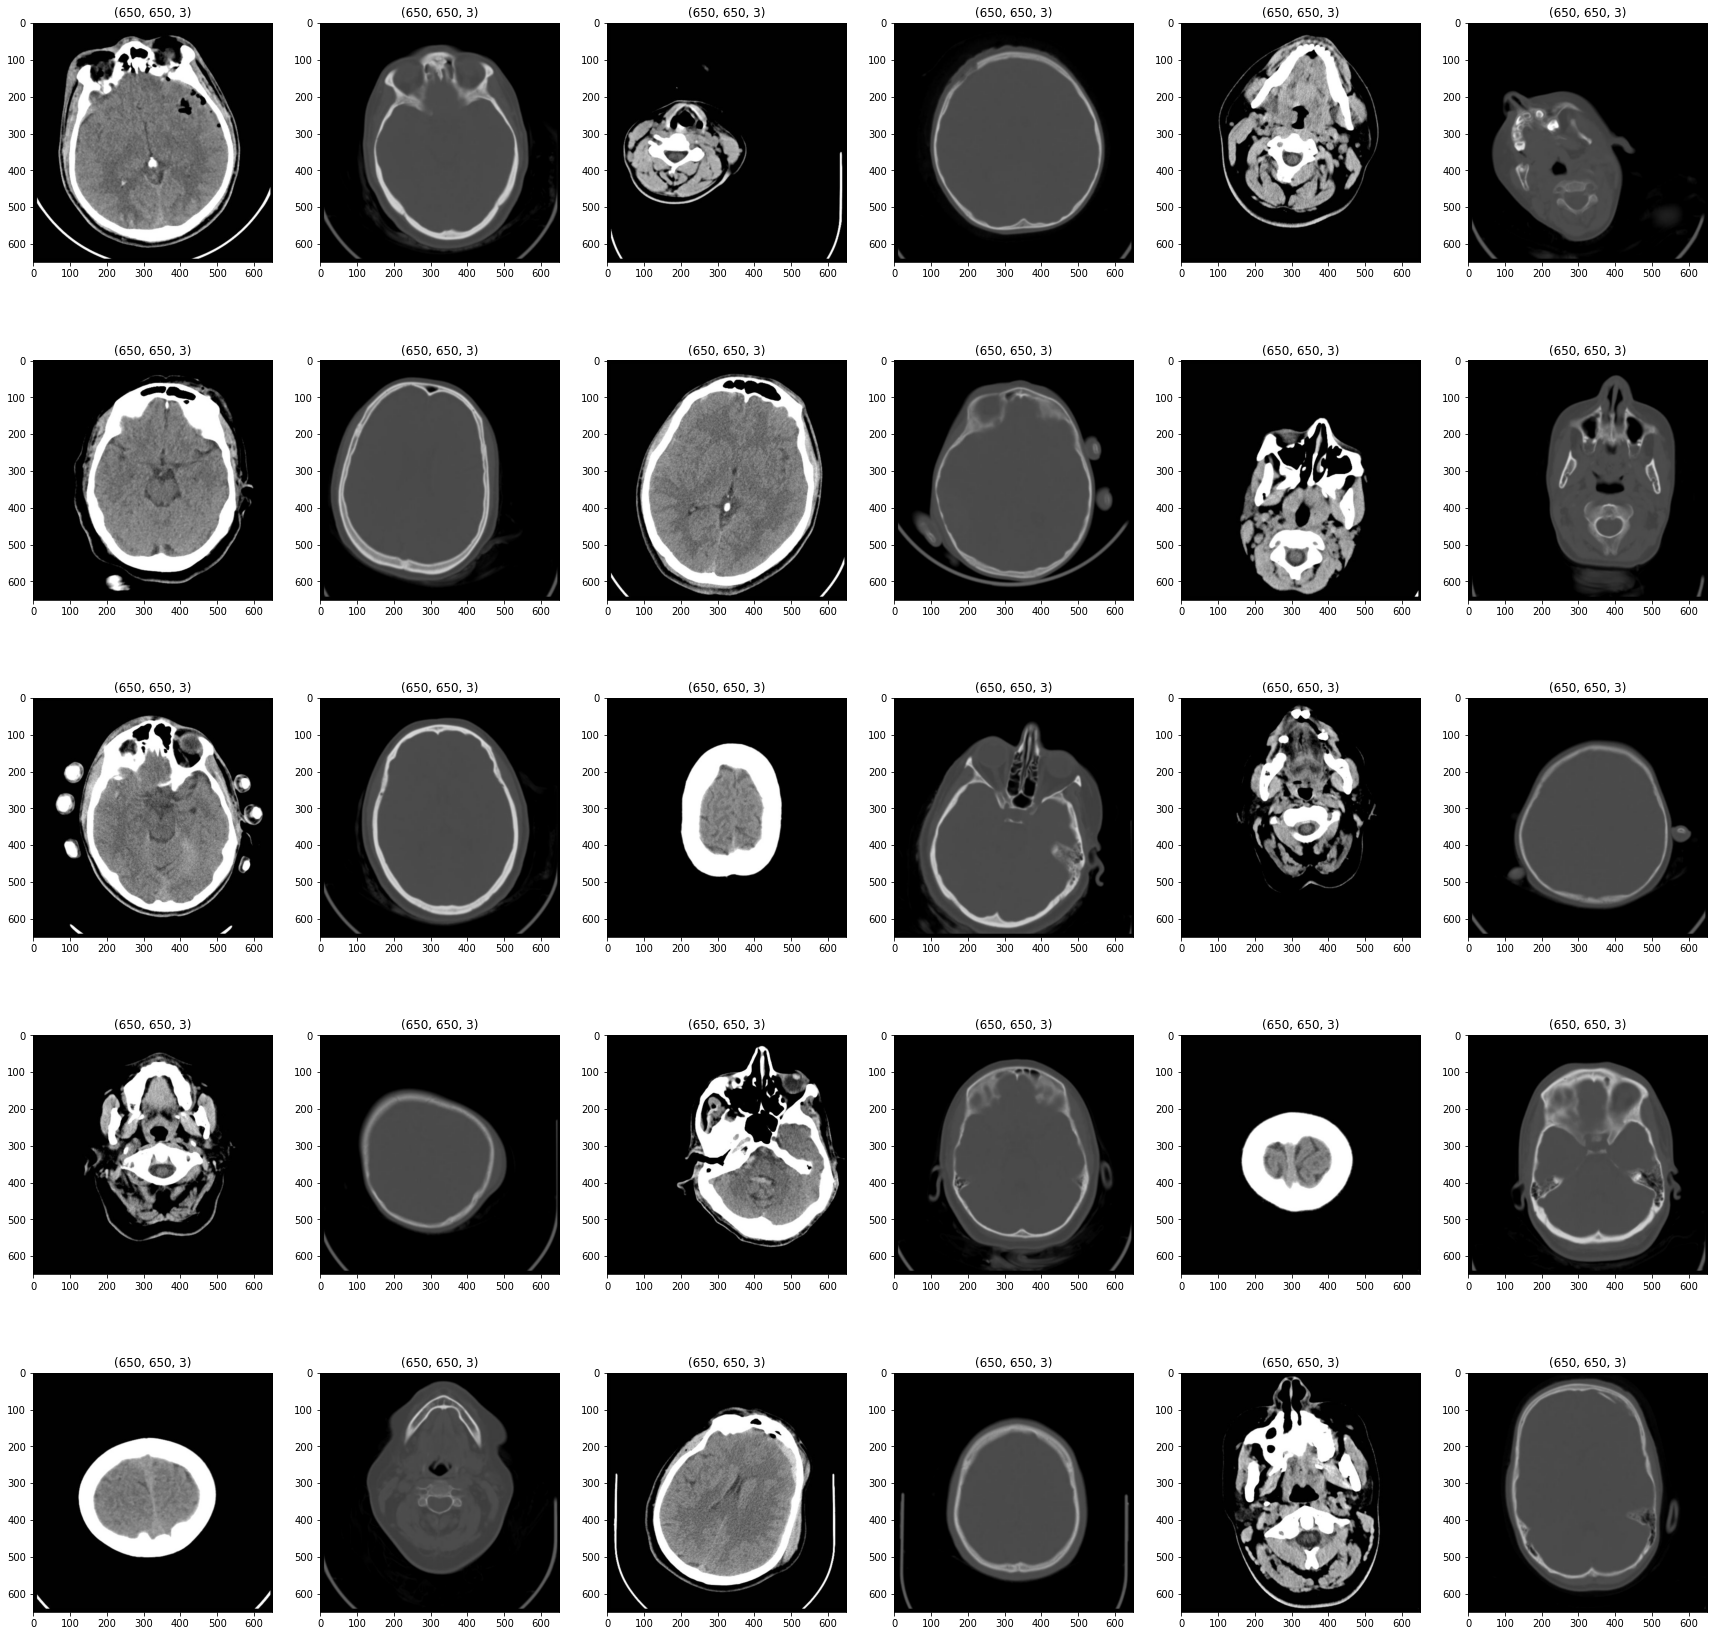

In [48]:
import cv2

data = diagnostics.sample(30)

plt.figure(figsize=(30, 30))
for i in range(5):
  for j in range(6):
    plt.subplot(5, 6, i*6+j+1)
    patient = data.iloc[i*6+j, 0]
    slice_ = data.iloc[i*6+j, 1] 
    if j % 2 == 0:
      window = 'brain'
    else:
      window = 'bone'
    path = f"{DATA_PATH}/Patients_CT/{patient:03d}/{window}/{slice_}.jpg"
    img = cv2.imread(path)
    plt.imshow(img)
    plt.title(f"{img.shape}")


In [49]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import cv2

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode



In [50]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [51]:
print(test_patients)

[52, 65, 105, 125, 101, 62, 64, 115, 119, 90, 102, 77, 104, 87, 89, 116, 49, 103, 70, 112, 109]


In [52]:
class BrainCTDataset(Dataset):
    """Brain CT Dataset."""

    def __init__(self, patients, csv_data, data_dir, is_train, transform=None):
        self.data = []
        for row_id, val in csv_data.iterrows():
          if val.PatientNumber in patients:
            self.data.append([
              val.PatientNumber, 
              val.SliceNumber, 
              val.No_Hemorrhage, 
              val.Fracture_Yes_No
            ])

        if is_train:
          healthy = [d for d in self.data if d[2] == 1] 
          hemorrhage = [d for d in self.data if d[2] == 0] 

          balanced_data = []
          for i in range(len(healthy)):
            balanced_data.append(healthy[i])
            balanced_data.append(hemorrhage[i % len(hemorrhage)])

          self.data = balanced_data
          
        self.data_dir = data_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        p_id, slice_id, hemo_label, frac_label = self.data[idx]
        
        brain_path = f"{self.data_dir}/Patients_CT/{p_id:03d}/brain/{slice_id}.jpg"
        bone_path = f"{self.data_dir}/Patients_CT/{p_id:03d}/bone/{slice_id}.jpg"

        brain_image = cv2.imread(brain_path, cv2.IMREAD_GRAYSCALE)
        bone_image = cv2.imread(bone_path, cv2.IMREAD_GRAYSCALE)

        if brain_image is None:
          print(f'Error loading image {brain_path}. Filling with zeros.')
          brain_image = np.zeros((500, 500), dtype=np.uint8)

        if bone_image is None:
          print(f'Error loading image {bone_path}. Filling with zeros.')
          bone_image = np.zeros((500, 500), dtype=np.uint8)

        if brain_image.shape[0] != 500 or brain_image.shape[1] != 500:
          brain_image = cv2.resize(brain_image, (500, 500))

        if bone_image.shape[0] != 500 or bone_image.shape[1] != 500:
          bone_image = cv2.resize(bone_image, (500, 500))

        doubled_bone_image = 2 * bone_image.astype(float)
        doubled_bone_image = np.clip(doubled_bone_image, 0, 255)
        doubled_bone_image = doubled_bone_image.astype(np.uint8)

        img = np.dstack([brain_image, bone_image, doubled_bone_image])

        if self.transform:
            img = self.transform(img)

        return img, hemo_label

# https://pytorch.org/vision/stable/auto_examples/plot_transforms.html#sphx-glr-auto-examples-plot-transforms-py
# Olhar AutoAugment no fim da página
train_transforms = transforms.Compose([
  transforms.ToTensor(),
  transforms.Resize([200, 200]),
  #transforms.RandomResizedCrop(size=(200, 200)),
  transforms.RandomHorizontalFlip(),
  transforms.RandomVerticalFlip(),
  transforms.GaussianBlur(kernel_size=3),
  #transforms.RandomPerspective(distortion_scale=0.15, p=0.1),
  transforms.RandomRotation(degrees=20),
])

test_transforms = transforms.Compose([
  transforms.ToTensor(),
  transforms.Resize([200, 200]),
])

train_ds = BrainCTDataset(
    train_patients, 
    diagnostics, 
    DATA_PATH, 
    is_train=True, 
    transform=train_transforms)

test_ds = BrainCTDataset(
    test_patients, 
    diagnostics, 
    DATA_PATH, 
    is_train=False,
    transform=test_transforms)

train_data = DataLoader(train_ds, batch_size=64, shuffle=True, num_workers=2)
test_data = DataLoader(test_ds, batch_size=64, shuffle=False, num_workers=2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

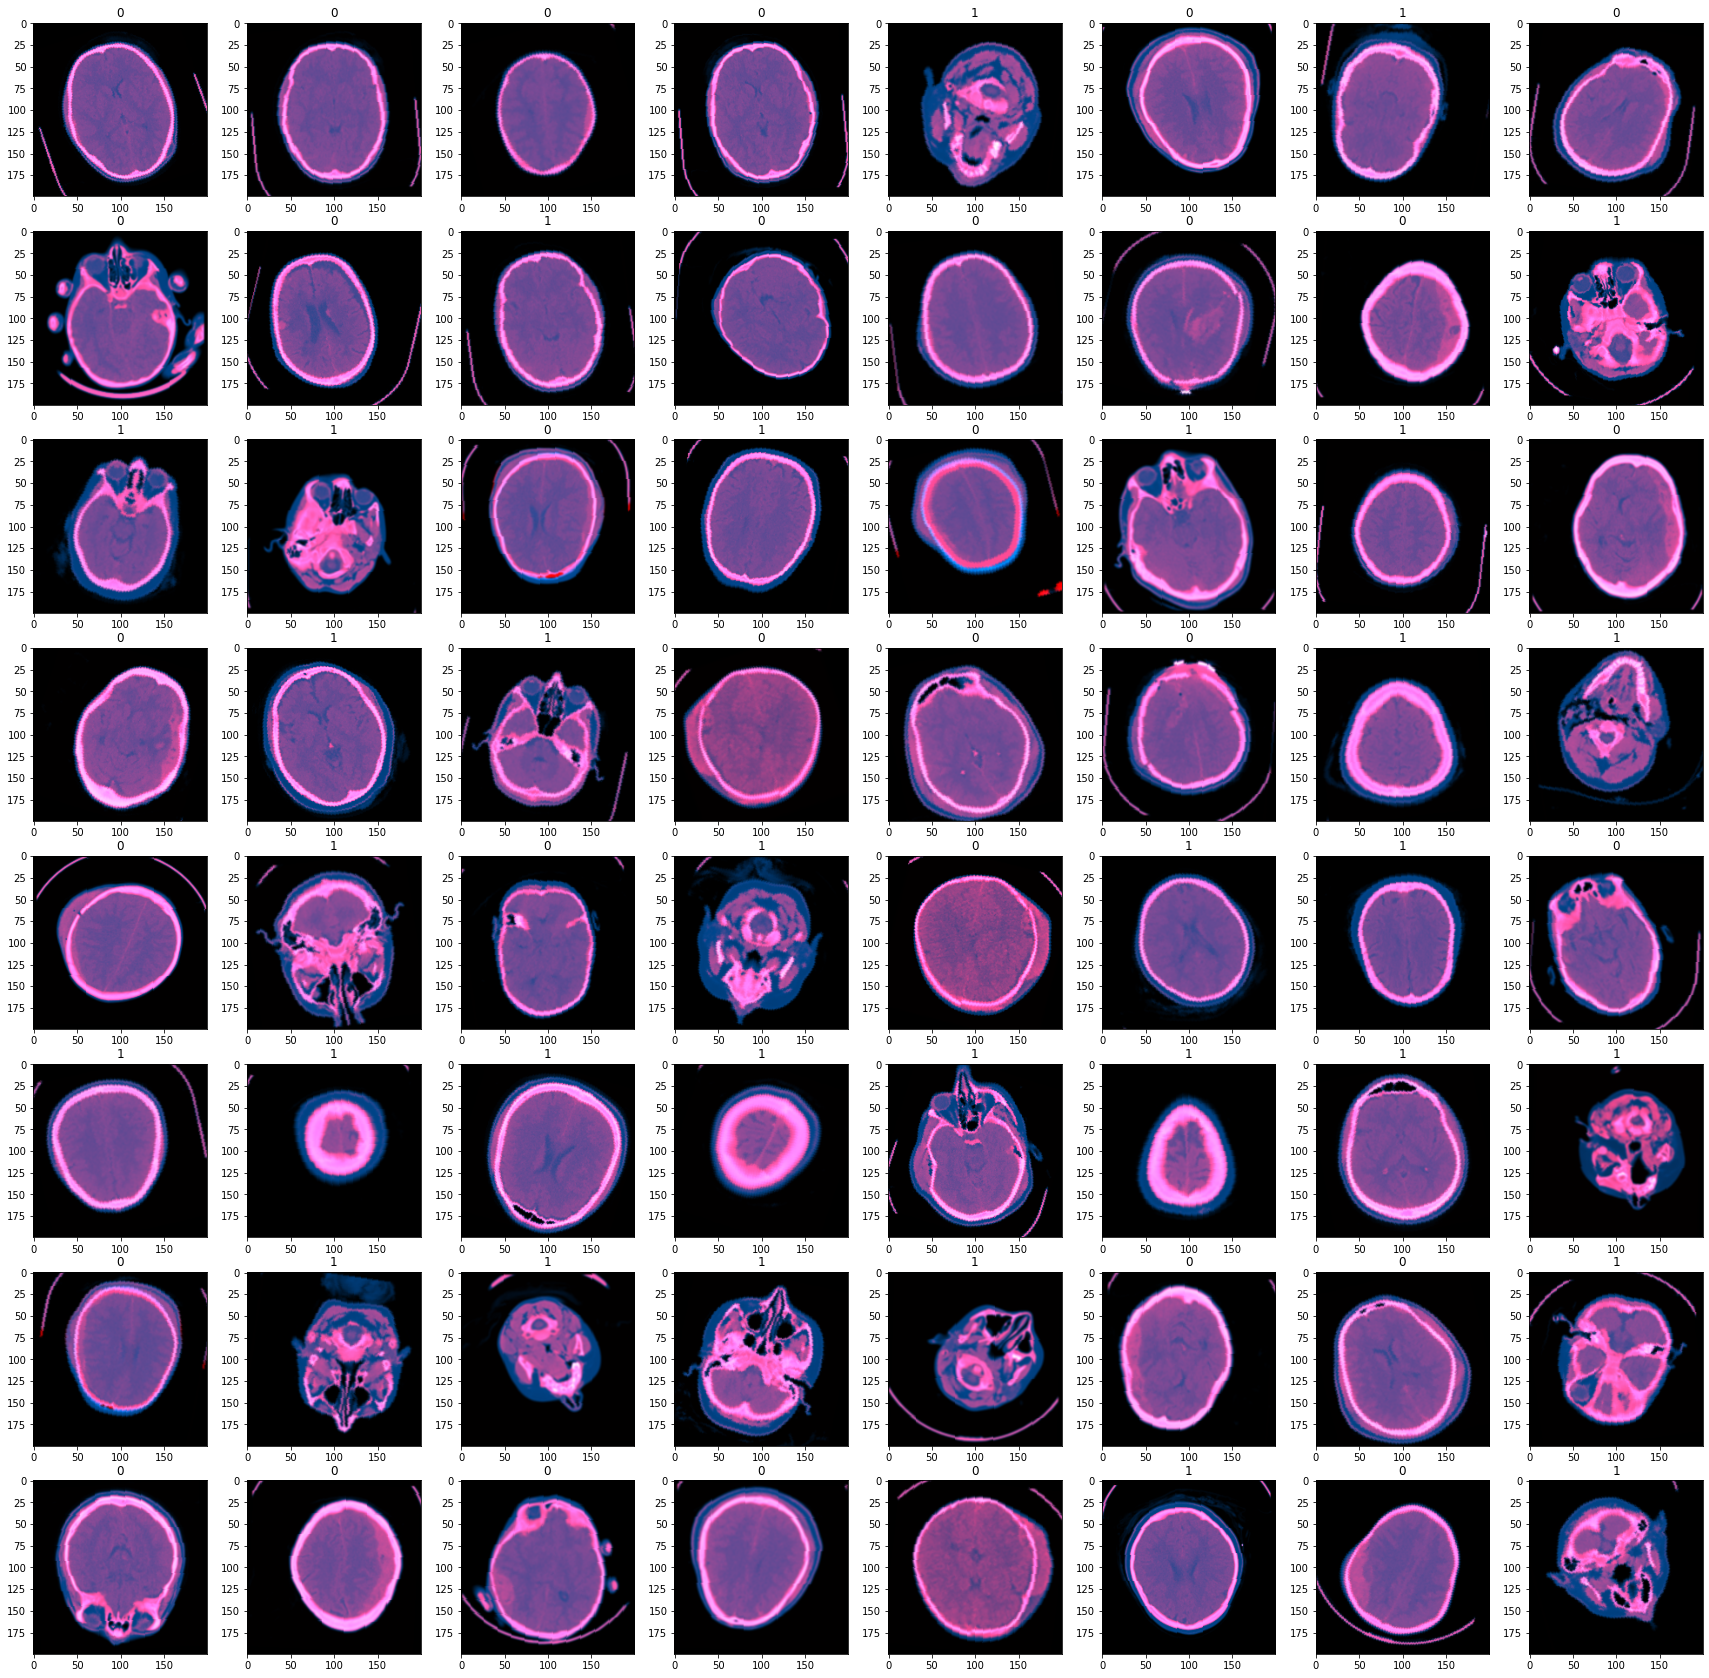

In [53]:
imgs, hemos = next(iter(train_data))

plt.figure(figsize=(30, 30))
for i, (img, label) in enumerate(zip(imgs, hemos)):
  plt.subplot(8, 8, i+1)
  img = img.numpy().transpose(1, 2, 0)
  plt.imshow(img)
  plt.title(f"{label}")


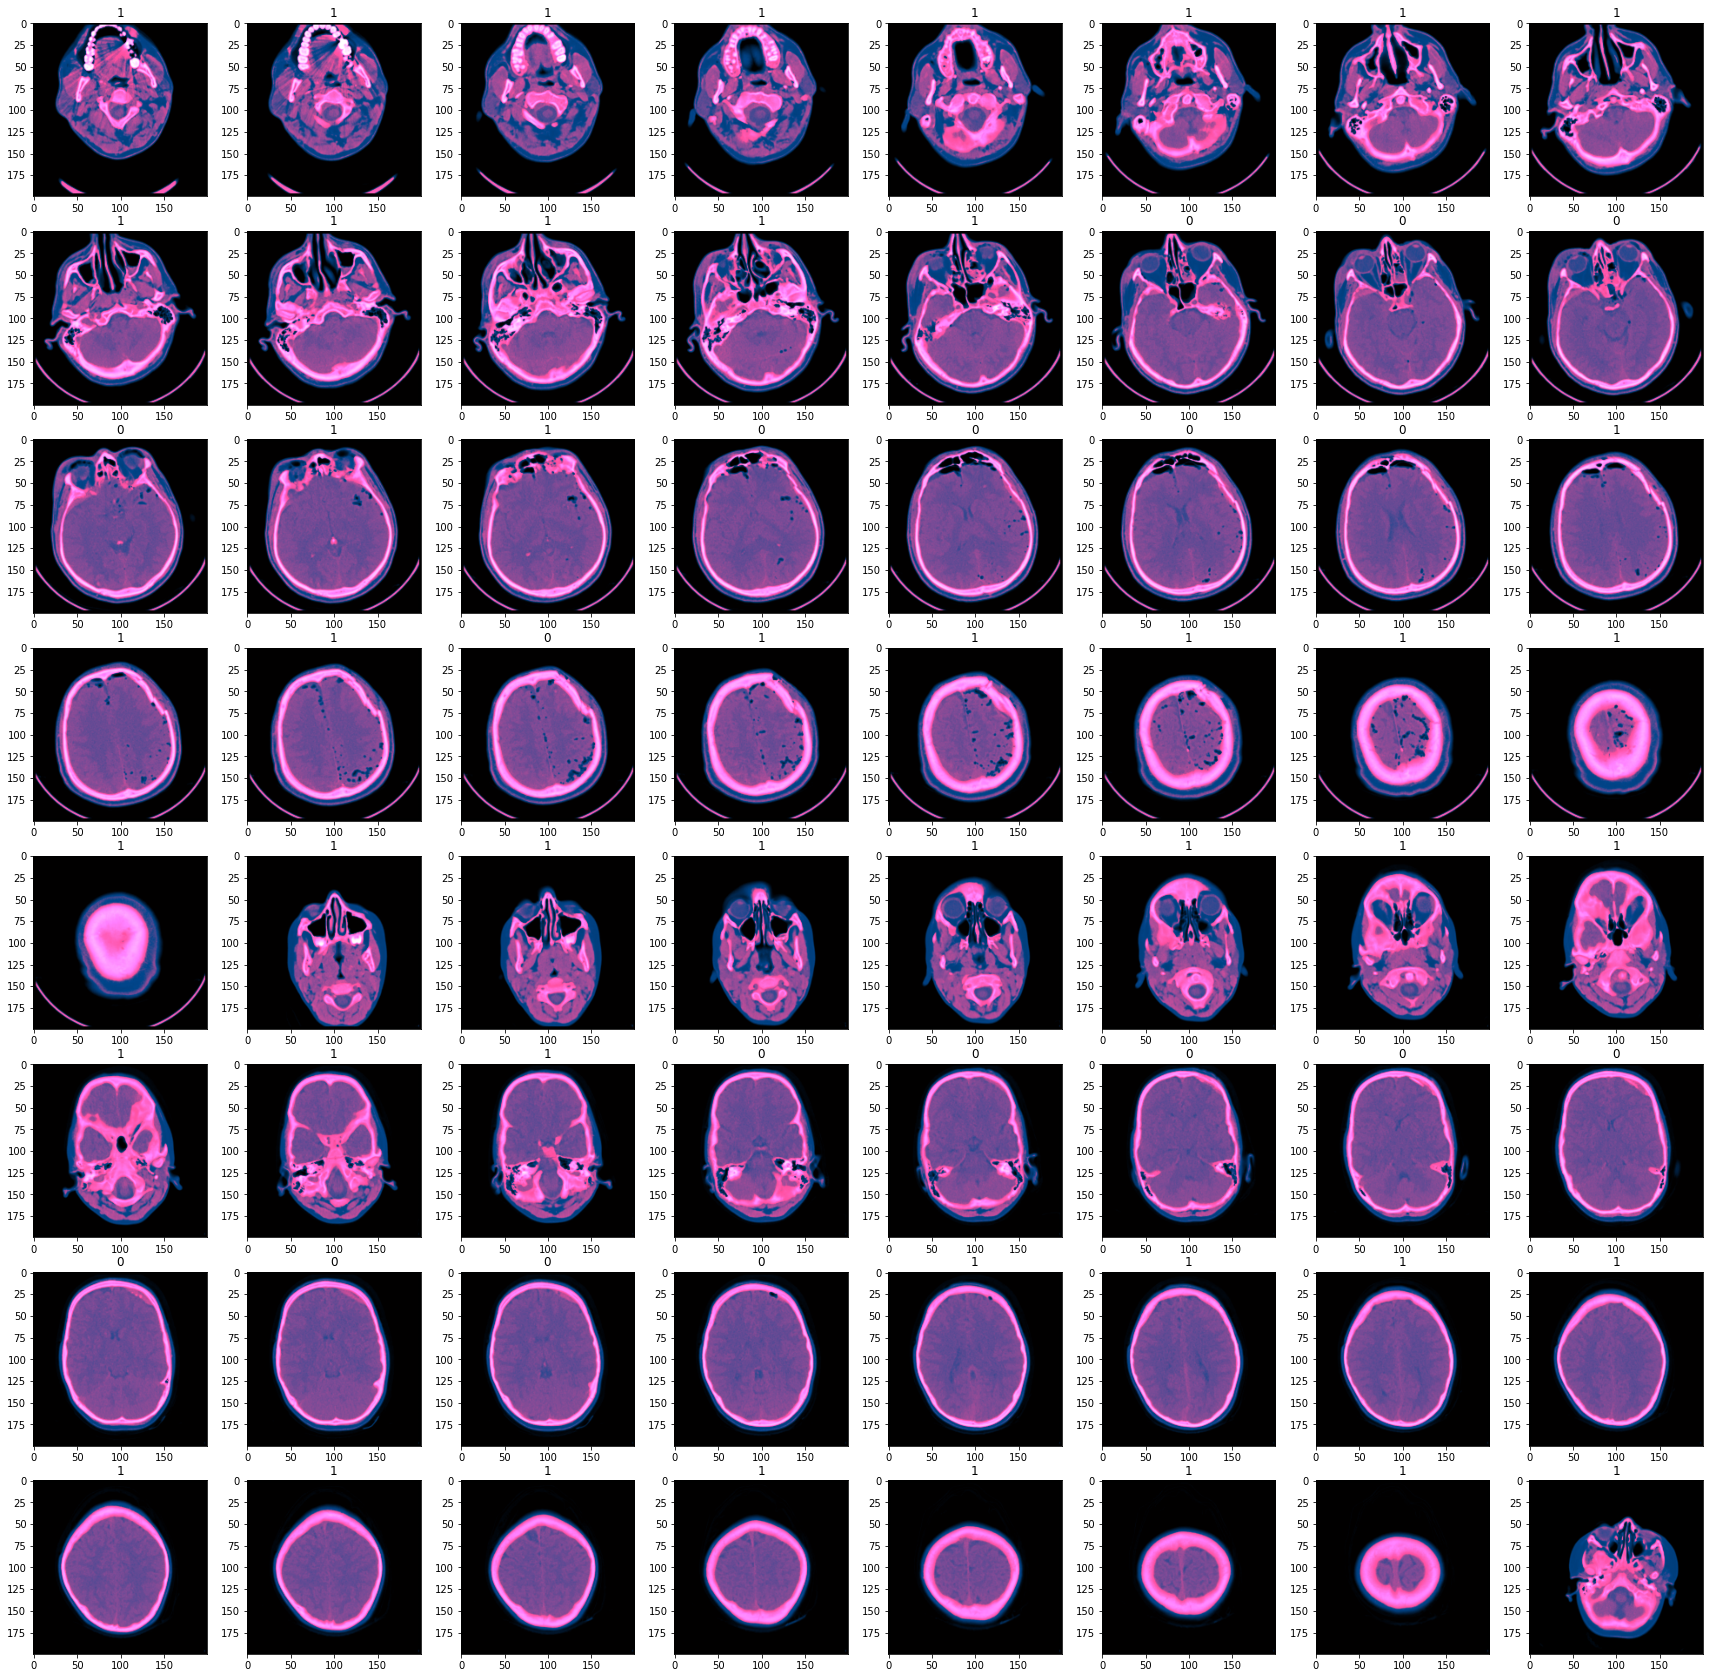

In [54]:
imgs, hemos = next(iter(test_data))

plt.figure(figsize=(30, 30))
for i, (img, label) in enumerate(zip(imgs, hemos)):
  plt.subplot(8, 8, i+1)
  img = img.numpy().transpose(1, 2, 0)
  plt.imshow(img)
  plt.title(f"{label}")



In [55]:
from torchvision import datasets, models

class SimpleCnn(nn.Module):
  def __init__(self):
    super(SimpleCnn, self).__init__()
    self.model = nn.Sequential(
      nn.Conv2d(3, 32, 3, 1),
      nn.MaxPool2d(2),
      nn.ReLU(),
      nn.Conv2d(32, 32, 3, 1),
      nn.MaxPool2d(2),
      nn.ReLU(),
      nn.Conv2d(32, 32, 3, 2),
      nn.MaxPool2d(2),
      nn.ReLU(),
      #nn.Dropout2d(0.25),
      nn.Flatten(),
      nn.Linear(7744, 256),
      nn.ReLU(),
      nn.Linear(256, 256),
      nn.ReLU(),
      nn.Linear(256, 2),
    )

  def forward(self, img):
    return self.model(img)


#net = SimpleCnn()
#print(net)
#net = net.to(device)

net = models.resnet18(pretrained=True)
num_ftrs = net.fc.in_features
net.fc = nn.Linear(num_ftrs, 2)
net = net.to(device)




In [56]:
loss_fn = nn.CrossEntropyLoss(reduction='sum')
optimizer = optim.Adam(net.parameters(), lr=0.001)
num_epochs = 20

from sklearn.metrics import confusion_matrix

In [57]:
from tqdm import tqdm 

train_losses, train_hemo_accuracies = [], []
val_losses, val_hemo_accuracies = [], []

best_val_acc = 0

# train loop
for epoch in range(num_epochs):
  train_loss = 0
  train_hemo_hits = 0

  net.train()
  preds = []
  trues = []

  for batch_idx, (img, label) in tqdm(enumerate(train_data)):
    img = img.to(device)
    label = label.to(device)
    optimizer.zero_grad() # reinitialize gradients
    logits = net(img)
    loss = loss_fn(logits, label)
    loss.backward()  # compute gradients in a backward pass
    optimizer.step()  # update weights
    train_loss += loss
    train_hemo_hits += torch.sum(torch.argmax(logits, dim=1) == label.data)
    trues += list(label.cpu().numpy())
    preds += list(np.argmax(logits.cpu().detach().numpy(), axis=-1))

  train_loss /= len(train_ds)
  train_hemo_acc = train_hemo_hits / len(train_ds)
  train_losses.append(train_loss)
  train_hemo_accuracies.append(train_hemo_acc)

  val_loss = 0
  val_hemo_hits = 0
  val_frac_hits = 0
  val_preds = []
  val_trues = []

  net.eval()
  with torch.no_grad():
    for batch_idx, (img, label) in tqdm(enumerate(test_data)):
      img = img.to(device)
      label = label.to(device)
      logits = net(img)
      loss = loss_fn(logits, label)
      val_loss += loss
      val_hemo_hits += torch.sum(torch.argmax(logits, dim=1) == label.data)
      val_trues += list(label.cpu().numpy())
      val_preds += list(np.argmax(logits.cpu().detach().numpy(), axis=-1))


  val_loss /= len(test_ds)
  val_losses.append(val_loss)
  val_hemo_acc = val_hemo_hits / len(test_ds)
  val_hemo_accuracies.append(val_hemo_acc)

  if val_hemo_acc > best_val_acc:
    torch.save(net, "best.pt")
    print("Saved best accuracy model.")
    best_val_acc = val_hemo_acc

  print(f"epoch: {epoch} loss: {train_loss:.3f} hemo_acc: {train_hemo_acc:.3f} val_loss: {val_loss:.3f} val_hemo_acc: {val_hemo_acc:.3f}")
  
  print("train confusion matrix:")
  print(confusion_matrix(trues, preds))

  print("val confusion matrix:")
  print(confusion_matrix(val_trues, val_preds))

  print("----------------\n")

  

2it [00:02,  1.17s/it]

Error loading image computed-tomography-ct-images/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0//Patients_CT/084/bone/36.jpg. Filling with zeros.


51it [00:48,  1.05it/s]
11it [00:06,  1.78it/s]


Saved best accuracy model.
epoch: 0 loss: 0.461 hemo_acc: 0.803 val_loss: 0.688 val_hemo_acc: 0.703
train confusion matrix:
[[1323  282]
 [ 351 1254]]
val confusion matrix:
[[ 67   1]
 [191 387]]
----------------



32it [00:31,  1.20it/s]

Error loading image computed-tomography-ct-images/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0//Patients_CT/084/bone/36.jpg. Filling with zeros.


51it [00:48,  1.06it/s]
11it [00:06,  1.78it/s]


Saved best accuracy model.
epoch: 1 loss: 0.301 hemo_acc: 0.870 val_loss: 0.438 val_hemo_acc: 0.896
train confusion matrix:
[[1455  150]
 [ 268 1337]]
val confusion matrix:
[[  6  62]
 [  5 573]]
----------------



15it [00:15,  1.06s/it]

Error loading image computed-tomography-ct-images/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0//Patients_CT/084/bone/36.jpg. Filling with zeros.


51it [00:48,  1.04it/s]
11it [00:06,  1.79it/s]

epoch: 2 loss: 0.270 hemo_acc: 0.881 val_loss: 0.355 val_hemo_acc: 0.879
train confusion matrix:
[[1447  158]
 [ 225 1380]]
val confusion matrix:
[[ 14  54]
 [ 24 554]]
----------------




21it [00:21,  1.06s/it]

Error loading image computed-tomography-ct-images/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0//Patients_CT/084/bone/36.jpg. Filling with zeros.


51it [00:48,  1.04it/s]
11it [00:06,  1.78it/s]

epoch: 3 loss: 0.254 hemo_acc: 0.893 val_loss: 0.464 val_hemo_acc: 0.895
train confusion matrix:
[[1471  134]
 [ 209 1396]]
val confusion matrix:
[[  0  68]
 [  0 578]]
----------------




42it [00:41,  1.13it/s]

Error loading image computed-tomography-ct-images/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0//Patients_CT/084/bone/36.jpg. Filling with zeros.


51it [00:48,  1.05it/s]
11it [00:06,  1.76it/s]

epoch: 4 loss: 0.220 hemo_acc: 0.910 val_loss: 0.360 val_hemo_acc: 0.893
train confusion matrix:
[[1488  117]
 [ 173 1432]]
val confusion matrix:
[[  0  68]
 [  1 577]]
----------------




18it [00:17,  1.16it/s]

Error loading image computed-tomography-ct-images/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0//Patients_CT/084/bone/36.jpg. Filling with zeros.


51it [00:48,  1.05it/s]
11it [00:06,  1.76it/s]

epoch: 5 loss: 0.214 hemo_acc: 0.916 val_loss: 0.616 val_hemo_acc: 0.774
train confusion matrix:
[[1508   97]
 [ 173 1432]]
val confusion matrix:
[[ 55  13]
 [133 445]]
----------------




2it [00:02,  1.13s/it]

Error loading image computed-tomography-ct-images/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0//Patients_CT/084/bone/36.jpg. Filling with zeros.


51it [00:48,  1.05it/s]
11it [00:06,  1.75it/s]

epoch: 6 loss: 0.192 hemo_acc: 0.923 val_loss: 0.417 val_hemo_acc: 0.873
train confusion matrix:
[[1504  101]
 [ 147 1458]]
val confusion matrix:
[[ 22  46]
 [ 36 542]]
----------------




12it [00:12,  1.12it/s]

Error loading image computed-tomography-ct-images/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0//Patients_CT/084/bone/36.jpg. Filling with zeros.


51it [00:48,  1.04it/s]
11it [00:06,  1.75it/s]

epoch: 7 loss: 0.172 hemo_acc: 0.933 val_loss: 1.116 val_hemo_acc: 0.655
train confusion matrix:
[[1512   93]
 [ 122 1483]]
val confusion matrix:
[[ 62   6]
 [217 361]]
----------------




22it [00:21,  1.16it/s]

Error loading image computed-tomography-ct-images/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0//Patients_CT/084/bone/36.jpg. Filling with zeros.


51it [00:48,  1.05it/s]
42it [00:40,  1.16it/s]

Error loading image computed-tomography-ct-images/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0//Patients_CT/084/bone/36.jpg. Filling with zeros.


51it [00:48,  1.05it/s]
11it [00:06,  1.80it/s]

epoch: 9 loss: 0.157 hemo_acc: 0.944 val_loss: 0.522 val_hemo_acc: 0.878
train confusion matrix:
[[1539   66]
 [ 113 1492]]
val confusion matrix:
[[  7  61]
 [ 18 560]]
----------------




28it [00:27,  1.14it/s]

Error loading image computed-tomography-ct-images/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0//Patients_CT/084/bone/36.jpg. Filling with zeros.


51it [00:50,  1.02it/s]
11it [00:06,  1.67it/s]

epoch: 10 loss: 0.126 hemo_acc: 0.953 val_loss: 0.452 val_hemo_acc: 0.890
train confusion matrix:
[[1545   60]
 [  92 1513]]
val confusion matrix:
[[  9  59]
 [ 12 566]]
----------------




17it [00:17,  1.02s/it]

Error loading image computed-tomography-ct-images/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0//Patients_CT/084/bone/36.jpg. Filling with zeros.


51it [00:48,  1.06it/s]
11it [00:06,  1.82it/s]

epoch: 11 loss: 0.131 hemo_acc: 0.952 val_loss: 0.374 val_hemo_acc: 0.864
train confusion matrix:
[[1539   66]
 [  88 1517]]
val confusion matrix:
[[ 33  35]
 [ 53 525]]
----------------




16it [00:15,  1.18it/s]

Error loading image computed-tomography-ct-images/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0//Patients_CT/084/bone/36.jpg. Filling with zeros.


51it [00:47,  1.07it/s]
11it [00:06,  1.80it/s]

epoch: 12 loss: 0.113 hemo_acc: 0.959 val_loss: 0.351 val_hemo_acc: 0.867
train confusion matrix:
[[1554   51]
 [  81 1524]]
val confusion matrix:
[[ 24  44]
 [ 42 536]]
----------------




42it [00:40,  1.18it/s]

Error loading image computed-tomography-ct-images/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0//Patients_CT/084/bone/36.jpg. Filling with zeros.


51it [00:47,  1.07it/s]
11it [00:06,  1.79it/s]


Saved best accuracy model.
epoch: 13 loss: 0.112 hemo_acc: 0.959 val_loss: 0.326 val_hemo_acc: 0.898
train confusion matrix:
[[1555   50]
 [  81 1524]]
val confusion matrix:
[[ 29  39]
 [ 27 551]]
----------------



30it [00:28,  1.19it/s]

Error loading image computed-tomography-ct-images/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0//Patients_CT/084/bone/36.jpg. Filling with zeros.


51it [00:47,  1.07it/s]
11it [00:06,  1.80it/s]

epoch: 14 loss: 0.096 hemo_acc: 0.966 val_loss: 0.379 val_hemo_acc: 0.876
train confusion matrix:
[[1558   47]
 [  63 1542]]
val confusion matrix:
[[ 37  31]
 [ 49 529]]
----------------




30it [00:28,  1.22it/s]

Error loading image computed-tomography-ct-images/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0//Patients_CT/084/bone/36.jpg. Filling with zeros.


51it [00:46,  1.09it/s]
11it [00:06,  1.81it/s]

epoch: 15 loss: 0.093 hemo_acc: 0.967 val_loss: 0.377 val_hemo_acc: 0.878
train confusion matrix:
[[1568   37]
 [  70 1535]]
val confusion matrix:
[[ 27  41]
 [ 38 540]]
----------------




32it [00:30,  1.03it/s]

Error loading image computed-tomography-ct-images/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0//Patients_CT/084/bone/36.jpg. Filling with zeros.


51it [00:47,  1.07it/s]
11it [00:06,  1.75it/s]

epoch: 16 loss: 0.094 hemo_acc: 0.966 val_loss: 0.365 val_hemo_acc: 0.887
train confusion matrix:
[[1564   41]
 [  68 1537]]
val confusion matrix:
[[ 17  51]
 [ 22 556]]
----------------




34it [00:32,  1.19it/s]

Error loading image computed-tomography-ct-images/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0//Patients_CT/084/bone/36.jpg. Filling with zeros.


51it [00:48,  1.06it/s]
11it [00:06,  1.74it/s]

epoch: 17 loss: 0.078 hemo_acc: 0.975 val_loss: 0.358 val_hemo_acc: 0.893
train confusion matrix:
[[1570   35]
 [  46 1559]]
val confusion matrix:
[[ 21  47]
 [ 22 556]]
----------------




44it [00:42,  1.16it/s]

Error loading image computed-tomography-ct-images/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0//Patients_CT/084/bone/36.jpg. Filling with zeros.


51it [00:48,  1.06it/s]
11it [00:06,  1.71it/s]

epoch: 18 loss: 0.080 hemo_acc: 0.974 val_loss: 0.686 val_hemo_acc: 0.810
train confusion matrix:
[[1569   36]
 [  49 1556]]
val confusion matrix:
[[ 29  39]
 [ 84 494]]
----------------




14it [00:13,  1.14it/s]

Error loading image computed-tomography-ct-images/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0//Patients_CT/084/bone/36.jpg. Filling with zeros.


51it [00:48,  1.06it/s]
11it [00:06,  1.76it/s]

epoch: 19 loss: 0.063 hemo_acc: 0.976 val_loss: 0.331 val_hemo_acc: 0.875
train confusion matrix:
[[1577   28]
 [  50 1555]]
val confusion matrix:
[[ 32  36]
 [ 45 533]]
----------------



Text(0.5, 1.0, 'hemo accuracy')

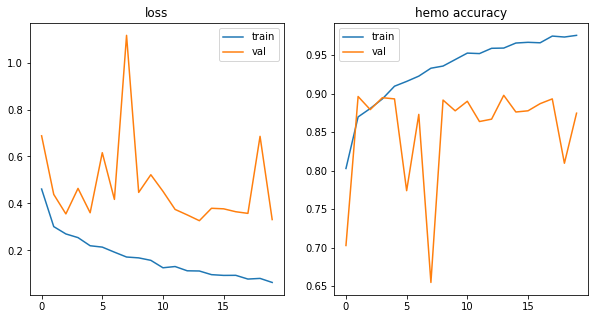

In [58]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')
plt.legend()
plt.title("loss")

plt.subplot(1, 2, 2)
plt.plot(train_hemo_accuracies, label='train')
plt.plot(val_hemo_accuracies, label='val')
plt.legend()
plt.title("hemo accuracy")



In [59]:
pred_hemo = []
true_hemo = []

net.eval()

with torch.no_grad():
  for batch_idx, (img, label) in enumerate(test_data):
    img = img.to(device)
    logits = net(img)
    logits = logits.to('cpu')
    
    pred_hemo += list(torch.argmax(logits, dim=1).numpy())
    true_hemo += list(label.numpy())
    
print("OK!")

OK!


In [60]:
from sklearn.metrics import confusion_matrix

print("CONFUSION MATRIX HEMO:")
print(confusion_matrix(true_hemo, pred_hemo))


CONFUSION MATRIX HEMO:
[[ 32  36]
 [ 45 533]]


In [61]:
from sklearn.metrics import classification_report

print("CLASSIFICATION REPORT HEMO:")
print(classification_report(true_hemo, pred_hemo))



CLASSIFICATION REPORT HEMO:
              precision    recall  f1-score   support

           0       0.42      0.47      0.44        68
           1       0.94      0.92      0.93       578

    accuracy                           0.87       646
   macro avg       0.68      0.70      0.69       646
weighted avg       0.88      0.87      0.88       646



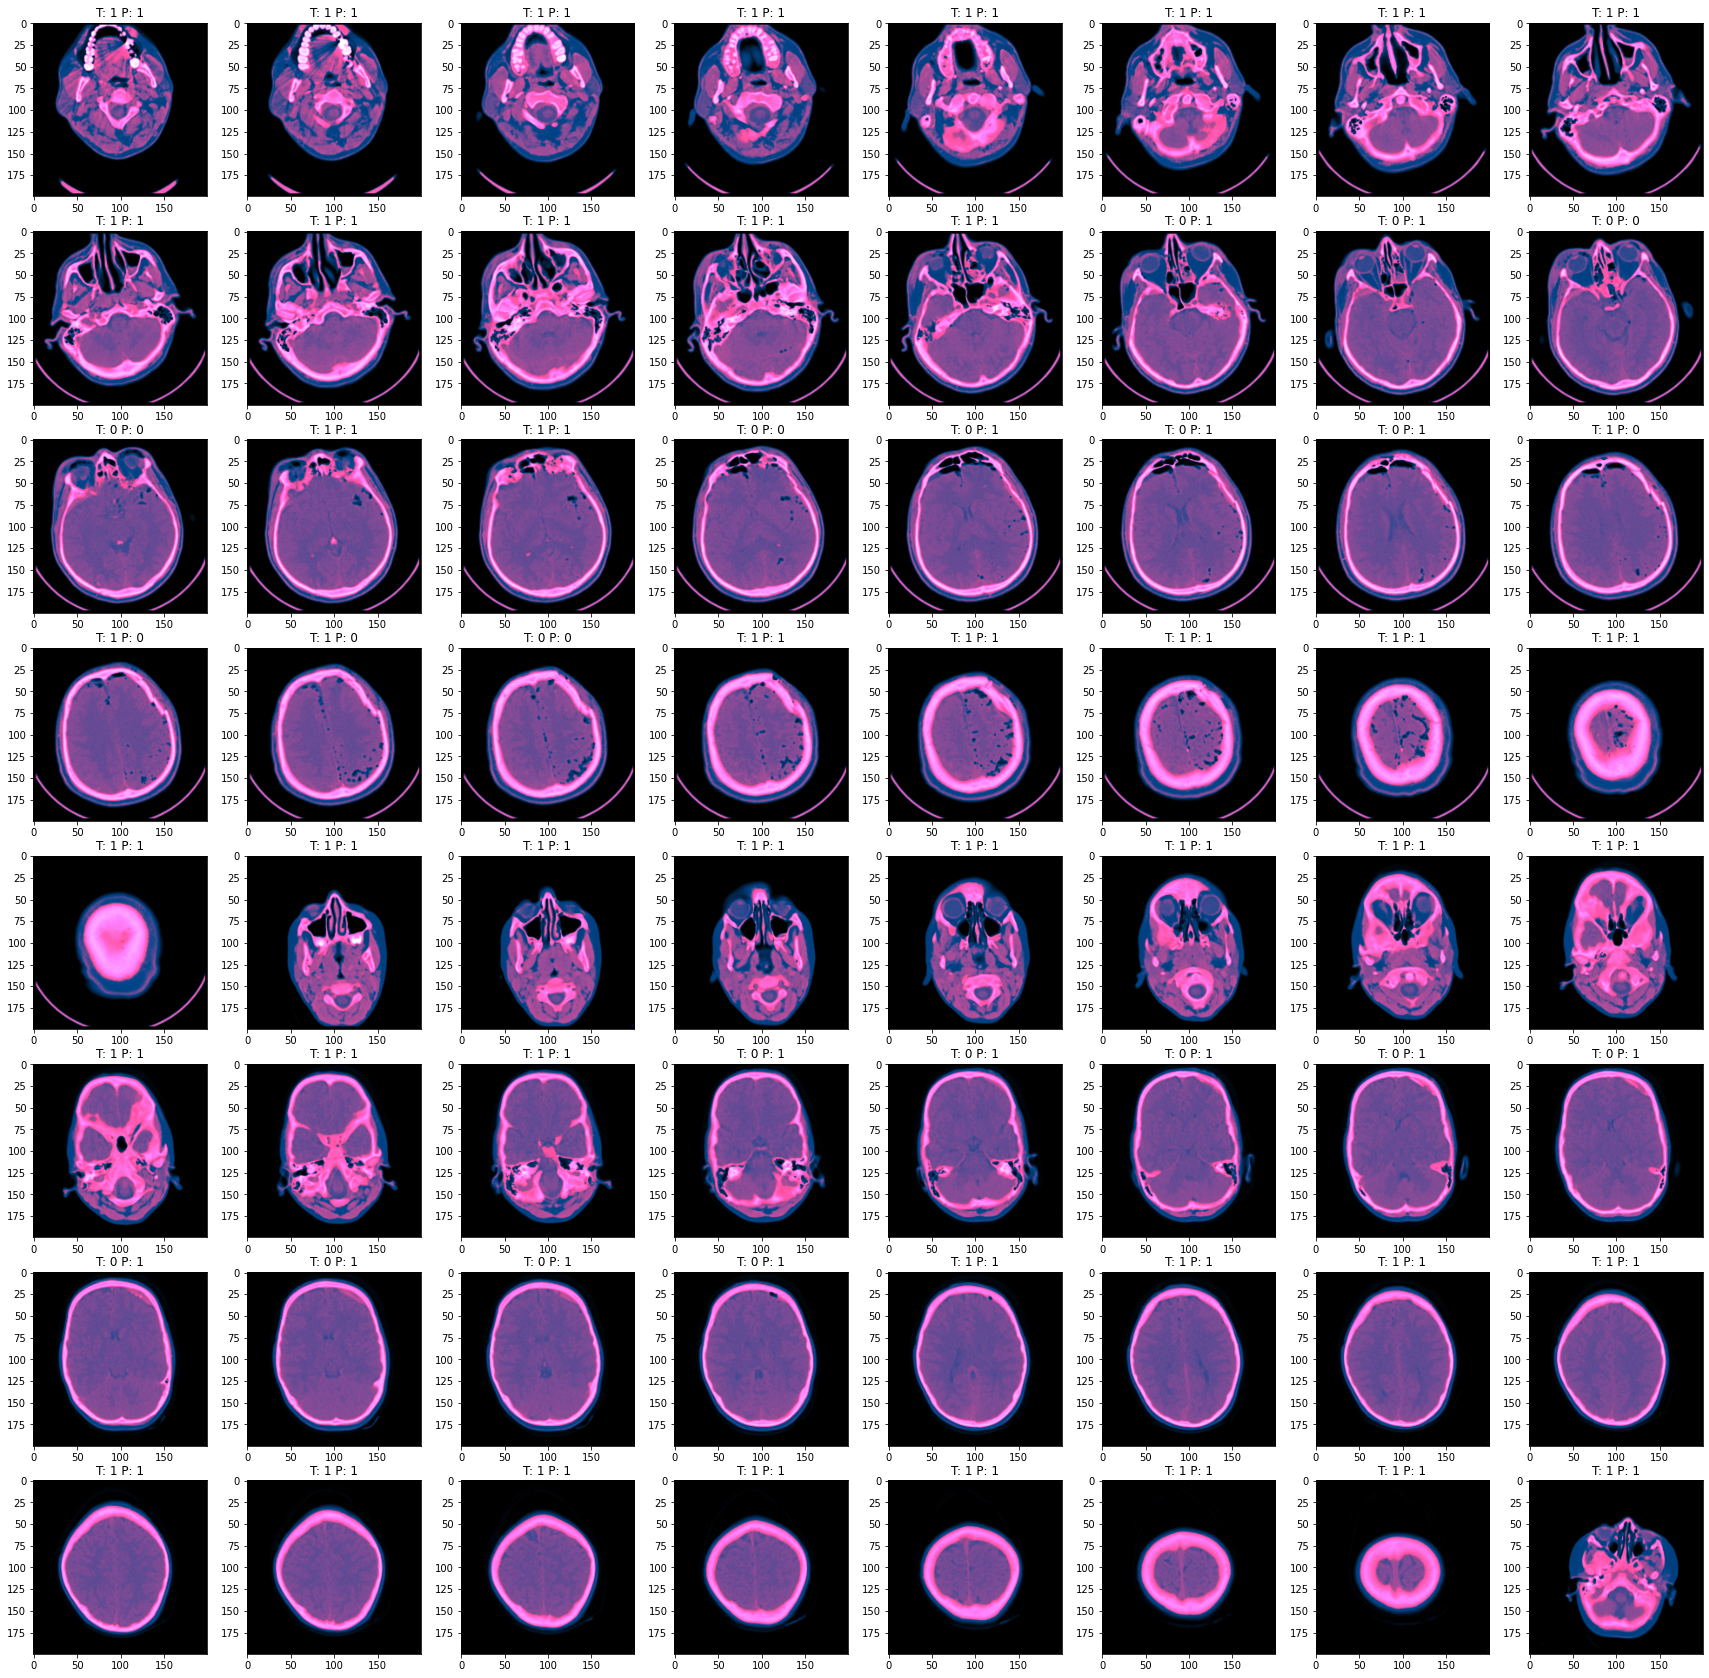

In [62]:

imgs, labels = next(iter(test_data))
imgs = imgs.to(device)

net.eval()
with torch.no_grad():
  preds = net(imgs)


plt.figure(figsize=(30, 30))
for i, (img, label, pred) in enumerate(zip(imgs, labels, preds)):
  plt.subplot(8, 8, i+1)
  img = img.cpu().numpy().transpose(1, 2, 0)
  plt.imshow(img)
  plt.title(f"T: {label} P: {torch.argmax(pred, dim=0).cpu().numpy()}")

In [63]:
torch.save(net, "model.pt")


In [64]:
files.download('model.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>